In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Sitting", "Jogging"]

In [3]:
df = pd.read_csv('C:/Users/abc99/OneDrive/바탕 화면/2023 2학기 파일 전체 모음/딥러닝응용/WISDM.csv', index_col=0)

In [4]:
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [5]:
df = df[['activity']]

In [6]:
df = pd.get_dummies(df, columns=['activity'])

In [7]:
df

,activity_Downstairs,activity_Jogging,activity_Sitting,activity_Standing,activity_Upstairs,activity_Walking
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
1098199,0,0,1,0,0,0
1098200,0,0,1,0,0,0
1098201,0,0,1,0,0,0
1098202,0,0,1,0,0,0


In [8]:
from sklearn.preprocessing import LabelEncoder

Jogging = df[df['activity_Jogging'] == 1].head(3700).copy()
Jogging['activity'] = 'Jogging'

Sitting = df[df['activity_Sitting'] == 1].head(4000).copy()
Sitting['activity'] = 'Sitting'

df_new = pd.concat([Jogging, Sitting])
df_new['activity'] = LabelEncoder().fit_transform(df_new['activity'])


In [9]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [10]:
# 데이터를 훈련 세트와 테스트 세트로 분리합니다
X_train, X_test = train_test_split(df_new, test_size=0.25, random_state=42)

# 정상 데이터만 사용하여 훈련합니다
normal = X_train[X_train['activity'] == 0]
X_train_normal_train = normal.drop(['activity'], axis=1).values

In [11]:
y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1).values

[ Noising ]

In [12]:
noise_factor = 0.4
X_train_noisy = X_train_normal_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_normal_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

In [13]:
input_dim = X_train_noisy.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [14]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h7", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train_noisy, X_train_normal_train,
                    epochs=10,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
77/87 [=========================>....] - ETA: 0s - loss: 0.0360 - accuracy: 0.9724

INFO:tensorflow:Assets written to: model.h7\assets


INFO:tensorflow:Assets written to: model.h7\assets


87/87 [==============================] - 2s 16ms/step - loss: 0.0324 - accuracy: 0.9755 - val_loss: 0.1384 - val_accuracy: 0.4800
Epoch 2/10
87/87 [==============================] - 0s 3ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1437 - val_accuracy: 0.4800
Epoch 3/10
87/87 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1509 - val_accuracy: 0.4800
Epoch 4/10
87/87 [==============================] - 0s 2ms/step - loss: 6.3496e-04 - accuracy: 1.0000 - val_loss: 0.1580 - val_accuracy: 0.4800
Epoch 5/10
87/87 [==============================] - 0s 3ms/step - loss: 5.0281e-04 - accuracy: 1.0000 - val_loss: 0.1610 - val_accuracy: 0.4800
Epoch 6/10
87/87 [==============================] - 0s 3ms/step - loss: 4.5936e-04 - accuracy: 1.0000 - val_loss: 0.1625 - val_accuracy: 0.4800
Epoch 7/10
87/87 [==============================] - 0s 3ms/step - loss: 4.3941e-04 - accuracy: 1.0000 - val_loss: 0.1621 - val_accuracy: 0.4800
Epoch 8/10
87/

In [15]:
y_pred = autoencoder.predict(X_test)

61/61 [==============================] - 0s 1ms/step


In [16]:
error_df = pd.DataFrame({'reconstruction_error': np.mean(np.power(X_test - y_pred, 2), axis=1),
                        'true_class': y_test})

In [17]:
threshold = 2.9

y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

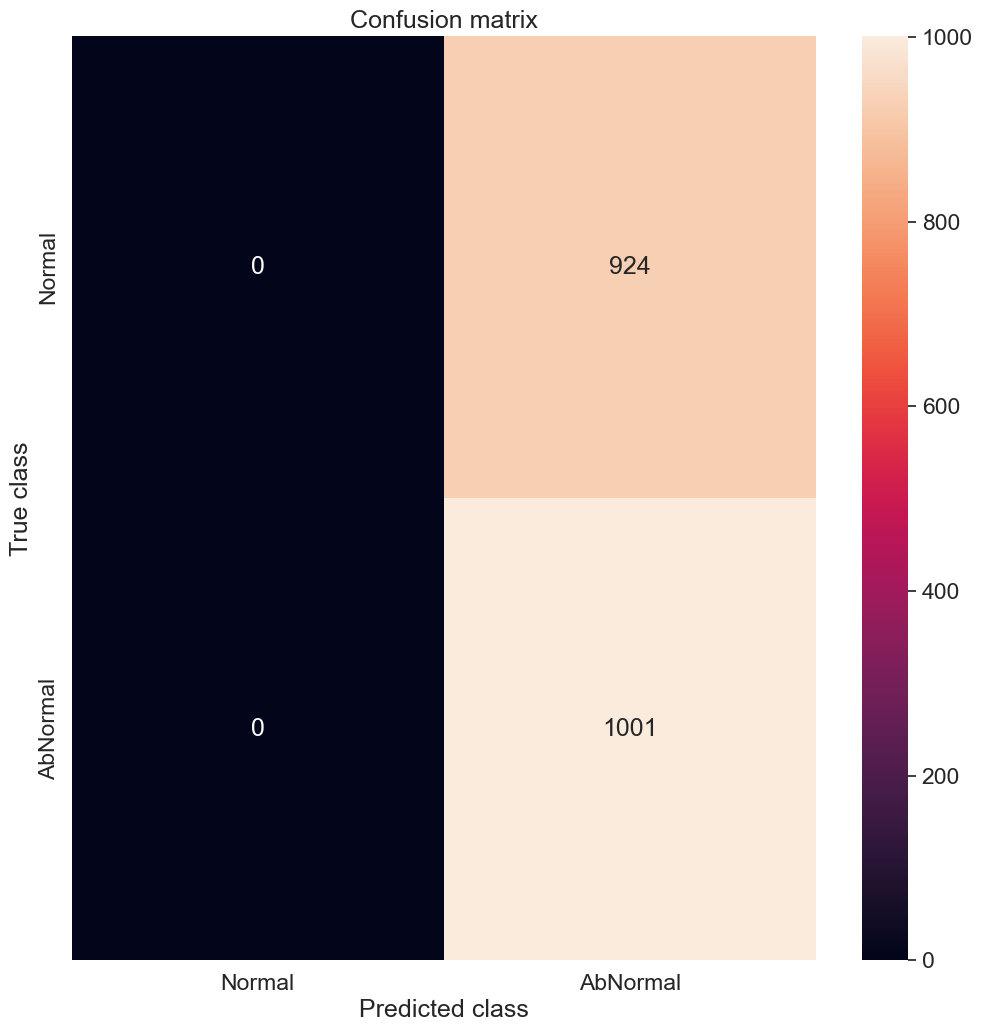

In [18]:
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [19]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print('Accuracy Score :',accuracy_score(error_df.true_class, y_pred))
print('Precision :',precision)
print('Recall :',recall)
print('F1 :',f1)

Accuracy Score : 0.52
Precision : 0.52
Recall : 1.0
F1 : 0.6842105263157895
